Data augmentation ideas:

1. Visualize and bandpass in frequency domain and apply monsoor bhais pipeline --> Rakshith

2. Use GAN's --> Harish

3. VAE--> Chethan  

4. Smote --> Harish 

5. New ideas -- All of us 

Model ideas:

1. CNN --> Harish 

2. CNN with RNN --> Chethan 

3. Transfer learning for LSTM/CNN --> Rakshith  look at what is available



In [2]:
import numpy as np 
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/gdrive')
data_path='/content/gdrive/MyDrive/EC247/'
    
import sys
sys.path.append(data_path)

from data_init_loading import *
from data_augmenters import *
from architectures import *
from architecture_utils import *

#Pytorch related stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
#data_path=r'C:/Users/raksh/Desktop/(EC 247)Neural Network and Deep Learning/Project/project_data_files/'
X_test = np.load(data_path+"X_test.npy")
y_test = np.load(data_path+"y_test.npy")
person_train_valid = np.load(data_path+"person_train_valid.npy")
X_train_valid = np.load(data_path+"X_train_valid.npy")
y_train_valid = np.load(data_path+"y_train_valid.npy")
person_test = np.load(data_path+"person_test.npy")
data_loader=data_init_loader()

y_train_valid,y_test=data_loader.make_labels(y_train_valid,y_test)

In [7]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [5]:

# Plot heat maps for each tasks
# for i in range(5):
#     data_loader.visualize_heatmap(X_train_valid,y_train_valid,person_train_valid,task=0)

In [ ]:
# Plot heat maps for each tasks
for i in range(5):
    data_loader.visualize_heatmap(X_train_valid,y_train_valid,person_train_valid,task=1)

In [ ]:
# Place holder for data augmentation
d_aug=data_augmenter()
X_time_flip,y_time_flip=d_aug.flip_across_time(X=X_train_valid,y=y_train_valid,time_axis=2)

for i in range(5):
    data_loader.visualize_heatmap(X_time_flip,y_time_flip,person_train_valid,task=1)

In [8]:
from torch.nn.modules.activation import ReLU
from torch.nn.modules import dropout
# Start training a vanilla LSTM on this data set


#This will go inside modules.py directory 

class LSTM(nn.Module):

  def __init__(self,input_size=22,hid_state=[64,64],num_rnns=2,dropout=0.6,num_classes=4) -> None:
      super(LSTM,self).__init__()
      # nn.LSTM is defined by pytorch already 
      # Please google for definition
      self.lstm_module=nn.LSTM(input_size=input_size,hidden_size=hid_state[0],num_layers=num_rnns,
                               batch_first=True,dropout=0)
      
      #Fully connected net
      self.fc_module=nn.Sequential(
         nn.Linear(hid_state[0],hid_state[0]),
         nn.ReLU(inplace=True) ,
         nn.BatchNorm1d(num_features=hid_state[0]),
         nn.Dropout(p=dropout),
         nn.Linear(hid_state[0],hid_state[1]),
         nn.ReLU(inplace=True) ,
         nn.BatchNorm1d(num_features=hid_state[1]),
         nn.Dropout(p=dropout),
         nn.Linear(hid_state[1],num_classes)

      )

  def forward(self,X):
    #X inputs are of form X= num_trails*num_channels*1*time_bins( as this format compatible for CNN)
    N,C,H,W=X.size()
    X=X.view(N,C,W)

    # This will give a tensor of shape num_trails*time_bins*num_channels
    X=X.permute(0,2,1)
    lstm_out,_=self.lstm_module(X)

    # LSTM output of size
    #Num trials,L(time bins),H(hidden state size)
    fc_out=self.fc_module(lstm_out[:,-1,:])
    return fc_out

(1692, 22, 1000) (1692,) (423, 22, 1000) (423,) (1692, 1)
In training#####:batches completed=1/27 The value of loss is 0.031851937770843504
In testing######### epochs_completed=1 The value of loss train is 1.389111911809003
In testing######### epochs completed=1 The value of train accuracy is 0.2641843971631206
In testing######### epochs_completed=1 The value of loss validation is 1.3964049134935652
In testing######### epochs completed=1 The value of validation accuracy is 0.23877068557919623
In testing######### epochs_completed=1 The value of loss test is 1.3925560031618391
In testing######### epochs completed=1 The value of test accuracy is 0.2595936794582393
Epochs done============== 1 / 50
In training#####:batches completed=1/27 The value of loss is 0.029454138278961182
In testing######### epochs_completed=2 The value of loss train is 1.3855466224529125
In testing######### epochs completed=2 The value of train accuracy is 0.26891252955082745
In testing######### epochs_completed=2 T

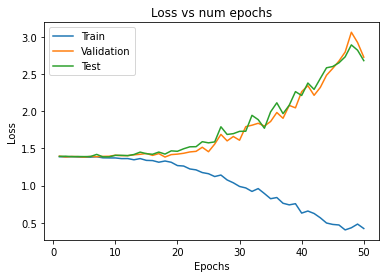

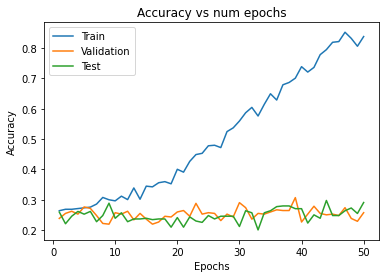

The best test accuracy obtained is =  0.2979683972911964


In [37]:
#Demo model which is a LSTM on our input data 
#********************************** Vanilla LSTM NO augmentation

d_init_loader=data_init_loader()
X_train,X_valid,y_train,y_valid,person_train,person_valid=d_init_loader.train_valid_split(X_train_valid,y_train_valid,person_train_valid)
save_path=data_path+'lstm_nodataaug'


#GPU related code if GPU is available device is GPU else it is CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


#At this point I have x_train, y_train, test and valid 
#Using the pytorch data loaders to get my things in place
dataloader_train,dataloader_test,dataloader_valid=torch_data_loader(X_train,y_train,X_test,y_test,X_valid,y_valid)

# I have all 3 data loaders now all I need to do is train the model first
all_data_loader=(dataloader_train,dataloader_test,dataloader_valid)

#Before that need to define an optimizer with pytorch and even before that make a model
model_lstm=LSTM().to(device)
optimizer=optim.Adam(model_lstm.parameters(),lr=5e-3)
#optimizer=optim.SGD(params=model_lstm.parameters(),lr=1e-3,momentum=0.9)
best_model,max_test_accu,eval_metrics=train_multi_epochs(model_lstm,optimizer,all_data_loader,num_epochs=50,printevery=50)
plot_train_test_curves(eval_metrics,save_path)
print("The best test accuracy obtained is = ",np.max(np.asarray(eval_metrics['test_loss_accuracy'])))
save_eval_metrics(eval_metrics,save_path)

Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
(6768, 22, 250) (6768,) (1692, 22, 250) (1692,) (0,)
In training#####:batches completed=1/106 The value of loss is 0.015423933267593384
In training#####:batches completed=101/106 The value of loss is 1.4570206570625306
In testing######### epochs_completed=1 The value of loss train is 1.3871770861013881
In testing######### epochs completed=1 The value of train accuracy is 0.26108156028368795
In testing######### epochs_completed=1 The value of loss validation is 1.38692636401565
In testing######### epochs completed=1 The value of validation accuracy is 0.2695

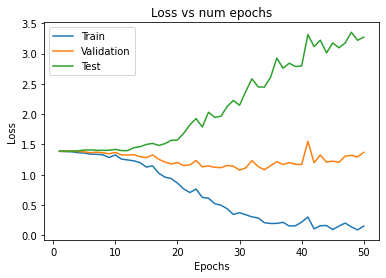

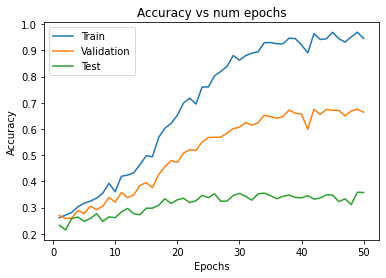

The best test accuracy obtained is =  0.35835214446952596


In [38]:
# Data augmented model
# ************************************LSTM with data augementation Sub sampling
daug_obj=data_augmenter()
X_train_valid_subsample,y_train_valid_subsample=daug_obj.sub_sample_maxpool(X_train_valid,y_train_valid,2,2,True)
X_test_subsample,y_test_subsample=daug_obj.sub_sample_maxpool(X_test,y_test,2,2,True)
#Demo model which is a LSTM on our input data 
save_path=data_path+'lstm_datasubsample'

d_init_loader=data_init_loader()

X_train,X_valid,y_train,y_valid,person_train,person_valid=d_init_loader.train_valid_split(X_train_valid_subsample,y_train_valid_subsample)


#GPU related code if GPU is available device is GPU else it is CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#At this point I have x_train, y_train, test and valid 
#Using the pytorch data loaders to get my things in place
dataloader_train,dataloader_test,dataloader_valid=torch_data_loader(X_train,y_train,X_test_subsample,y_test_subsample,X_valid,y_valid)

# I have all 3 data loaders now all I need to do is train the model first
all_data_loader=(dataloader_train,dataloader_test,dataloader_valid)

#Before that need to define an optimizer with pytorch and even before that make a model
model_lstm=LSTM().to(device)
optimizer=optim.Adam(model_lstm.parameters(),lr=5e-3)
#optimizer=optim.SGD(params=model_lstm.parameters(),lr=1e-3,momentum=0.9)
best_model,max_test_accu,eval_metrics=train_multi_epochs(model_lstm,optimizer,all_data_loader,num_epochs=50,printevery=100)
plot_train_test_curves(eval_metrics,save_path)
print("The best test accuracy obtained is = ",np.max(np.asarray(eval_metrics['test_loss_accuracy'])))
save_eval_metrics(eval_metrics,save_path)

(2115, 22, 1000)
(2115, 22, 1000)
Shape of X after trimming: (4230, 22, 500)
Shape of X after maxpooling: (4230, 22, 250)
Shape of X after averaging+noise and concatenating: (8460, 22, 250)
Shape of X after subsampling and concatenating: (16920, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
(13536, 22, 250) (13536,) (3384, 22, 250) (3384,) (0,)
In training#####:batches completed=1/212 The value of loss is 0.00590573787689209
In testing######### epochs_completed=1 The value of loss train is 1.3865915323203464
In testing######### epochs completed=1 The value of train accuracy is 0.25760933806146574
In testing######### epochs_completed=1 The value of loss validation is 1.3905650309796602
In testing######### epochs completed=1 The value of validation accuracy is 0.24497635933806147
In testing######### epochs_comp

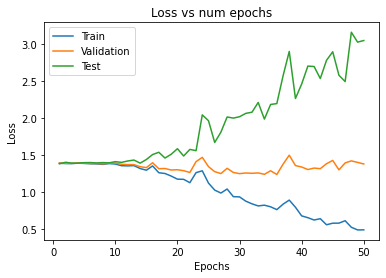

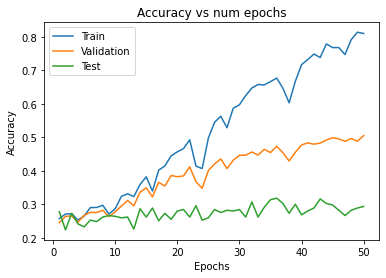

The best test accuracy obtained is =  0.3182844243792325


In [42]:
#************************************* Sub sample + flipping***********************************

#****************** LSTM with flipped data
# Data augmented model
# ************************************LSTM with data augementation Sub sampling
daugmenter=data_augmenter()
X_train_valid_flip,y_train_valid_flip = daugmenter.flip_across_time(X_train_valid,y_train_valid)

save_path=data_path+'lstm_datasubflip'
print(X_train_valid.shape)
print(X_train_valid_flip.shape)

X_train_valid_flip=np.concatenate((X_train_valid,X_train_valid_flip),axis=0)
y_train_valid_flip=np.concatenate((y_train_valid,y_train_valid_flip),axis=0)


X_train_valid_subsample,y_train_valid_subsample =daugmenter.sub_sample_maxpool(X_train_valid_flip,y_train_valid_flip,2,2,True)
X_test_subsample,y_test_subsample =daugmenter.sub_sample_maxpool(X_test,y_test,2,2,True)

d_init_loader=data_init_loader()

X_train,X_valid,y_train,y_valid,person_train,person_valid=d_init_loader.train_valid_split(X_train_valid_subsample,y_train_valid_subsample)

#GPU related code if GPU is available device is GPU else it is CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


#At this point I have x_train, y_train, test and valid 
#Using the pytorch data loaders to get my things in place
dataloader_train,dataloader_test,dataloader_valid=torch_data_loader(X_train,y_train,X_test,y_test,X_valid,y_valid)

# I have all 3 data loaders now all I need to do is train the model first
all_data_loader=(dataloader_train,dataloader_test,dataloader_valid)

#Before that need to define an optimizer with pytorch and even before that make a model
model_lstm=LSTM().to(device)
optimizer=optim.Adam(model_lstm.parameters(),lr=5e-3)
#optimizer=optim.SGD(params=model_lstm.parameters(),lr=1e-3,momentum=0.9)
best_model,max_test_accu,eval_metrics=train_multi_epochs(model_lstm,optimizer,all_data_loader,num_epochs=50,printevery=300) 
plot_train_test_curves(eval_metrics,save_path)
print("The best test accuracy obtained is = ",np.max(np.asarray(eval_metrics['test_loss_accuracy'])))
save_eval_metrics(eval_metrics,save_path)

